In [1]:
import pandas as pd
from scipy import signal
import tracker
from scipy.optimize import curve_fit
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import seaborn as sns
from cycler import cycle
from matplotlib.patches import Patch
from scipy.optimize import linear_sum_assignment


"""
重复滤波法提波峰步骤：
    1. 重复滤波得到所有波峰；
    2. 追踪波峰条纹；
    3. 确定静息值，滤除不必要的波峰条纹；

获得条纹区间：
    1. 读取过滤后的条纹
    2. 按主次条纹聚类
    3. 由条纹区间得到脉冲区间估计
    
获得脉冲区间估计：
"""

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'axes.titlesize': 14,
    'savefig.dpi': 300,
    'font.weight': 'bold'
})


class GetPP:

    def __init__(self):
        self.sig = None
        self.pp = None   # peak pillars
        self.i = None  # id
        self.initial_guess = [300, 1., 0.5]  # for curve fit

    def _rfa(self, vis=False):
        """
        Repetitive filtering algorithm.
        :param vis: 是否可视化。
        :return: the sorted peak pillars,
        """
        tra = tracker.Tracker()  # 调用MOT模型
        n = 200  # 重复滤波的次数
        points = []  # 波峰点
        win = np.ones(3)  # 窗口函数
        f = self.sig.copy()
        for i in range(n):
            f = np.convolve(win, f, mode="same") / sum(win)
            peaks, _ = signal.find_peaks(f)
            values = f[peaks]
            p = np.c_[peaks, i * np.ones_like(peaks), values]   # 为了画图方便的格式
            tra.predict()
            tra.update(p[:, [0, 2]])
            points.append(p)
        points = np.concatenate(points)
        df_dict = {"id": [], "loc": [], "h": []}
        for item in tra.tracks:  # 取出一直没被删除的目标的历史记录
            tra.records[item.id] = item.history
        for key, values in tra.records.items():
            for value in values:
                df_dict["id"].append(key)
                df_dict["loc"].append(value[0])
                df_dict["h"].append(value[1])
        self.pp = pd.DataFrame(df_dict) #
        # df.to_csv("mot_re.csv", index=False)

        if vis:
            images = []
            fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex="col")
            images.append(ax[0].plot(self.sig))
            ax[1].set_xlabel("position")
            ax[0].set_ylabel("iterations")
            ax[1].set_ylabel("iterations")
            for key in tra.records.keys():
                values = np.array(tra.records[key])
                ax[1].scatter(values[:, 0], np.arange(len(values[:, 0])), s=2)
            plt.show()
        return self.pp  # dataframe, id, loc, h

    @staticmethod
    def _func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))

    def _tan_estimator(self, alpha):
        dp = "../DetStageI/npy/knee/"
        fns = os.listdir(dp)
        arr = np.load(dp + fns[self.i])
        initial_guess = [1., 1., 0.5]
        x, y = arr[:, 0], arr[:, 1]
        y = 0.5 * y / y.max()
        params = curve_fit(self._func, x, y, p0=initial_guess)
        params = params[0]
        L, k, x0 = params
        x_a = x0 - (1. / k) * np.log(1. / (2 * alpha) * (L * k - 2 * alpha - np.sqrt((L * k) ** 2 - 4 * alpha * L * k)))
        return np.round(x_a, 3)

    def _traverse(self, vis=False):  # 分析用
        # 绘制logistic切线图，查看拟合效果
        h = np.arange(0.06, 0.5, 0.001)
        aver_h = self.pp.groupby("id")["h"].agg(["mean"]).sort_values(by="mean")
        result = [aver_h[aver_h['mean'] < threshold].shape[0] for threshold in h]

        params = curve_fit(self._func, h, np.array(result), p0=self.initial_guess)
        params = params[0]
        if vis:
            plt.plot(h, result, 'b-', label='data')
            plt.plot(h, self._func(h, *params), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(params))
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend()
            plt.savefig(f"pic/fit/{self.i}.png")
            plt.close()
        return np.c_[h, np.array(result)]

    def _filter_pp(self, theta, alpha, vis=False):
        # 跟据切线切点坐标，滤除多余柱状条纹
        grouped1 = self.pp.groupby("id")["h"].agg(["mean", "min", "max", "std", "size"])
        f1 = grouped1[(grouped1["size"] >= 2) & (grouped1["mean"] >= theta)]  # 初步筛选结果
        f2 = self.pp[self.pp["id"].isin(f1.index)]
        reindex = f2.set_index("id")  # the filtered stripes.
        if not os.path.exists(f"pic/stripe{alpha}"):
            os.makedirs(f"pic/stripe{alpha}")
        if vis:
            fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex='col')
            ax[0].plot(self.sig)
            ax[0].set_ylim([0, 2.])
            ax[0].set_ylabel("Amplitude", fontsize=16)
            for i in f1.index:
                tmp = reindex.xs(i)
                ax[1].scatter(tmp["loc"], np.arange(len(tmp["loc"])), s=2)
            ax[1].set_xlabel("Position", fontsize=16)
            ax[1].set_ylabel("Iteration", fontsize=16)
            plt.savefig(f"pic/stripe{alpha}/{self.i}.png")
            plt.close()
        return f2  # 过滤后的Dataframe。

    def run(self, sig, i):
        """
        执行整个流程
        :param sig: 输入信号，一维向量
        :param i: 编号（第几个信号）
        :return: None
        """
        self.sig = sig
        self.i = i
        pp = self._rfa(vis=False)  # 获得柱状条纹 散点图
        alpha = 1./16
        theta = self._tan_estimator(alpha=alpha)
        # print(i, "height threshold: ", theta)
        # self._traverse(vis=True)
        # # self._estimator()
        self.pp.to_csv(f"dataframe/fstripesRaw/{self.i}.csv", index=False)
        self._traverse(vis=True)
        filtered_pp = self._filter_pp(theta=theta, alpha=alpha, vis=True)   # dataframe: id, loc, h
        filtered_pp.to_csv(f"dataframe/fstripes/{self.i}.csv", index=False)


class StripeManager:
    # 条纹聚类，针对单一信号，给出脉冲区间
    def __init__(self, i, sig, csv_dp, k=4):
        self.i = i
        self.pairs = None
        self.stripeInterval = None
        self.pulseInterval = None
        self.sig = sig
        med = np.median(sig)
        mad = np.median(np.abs(sig - med))
        self.tau = med + mad
        self.csv_path = os.path.join(csv_dp, f"{i}.csv")
        self.outlier = med + mad * k

    def _assign_stripes(self, stripes, M=200):  # 条纹归属
        """
        对平行于y轴的条纹进行主次分类和归属计算

        :param stripes: List[dict] 输入条纹列表，每个条纹包含'x'坐标及'L'长度字段
        :param M: int 主条纹长度阈值
        :return: List[tuple] 返回元组列表，每个元组包含(主条纹, 附属次条纹列表)
        """
        # 阶段1：分离主次条纹

        masters = [s for s in stripes if s['L'] == M]
        secondary = [s for s in stripes if s['L'] < M]

        # 按x坐标对主条纹排序（解决距离相同时选较小x的需求）
        masters.sort(key=lambda x: x['x'])

        # 阶段2：建立主-次映射关系
        mapping = {id(m): (m, []) for m in masters}  # 使用对象id处理可能重复的字典

        for s in secondary:
            min_dist = float('inf')
            closest_master = None

            # 寻找最近主条纹
            for m in masters:
                dist = abs(m['x'] - s['x'])
                if dist < min_dist:
                    min_dist = dist
                    closest_master = m
                elif dist == min_dist and m['x'] < closest_master['x']:
                    closest_master = m

            # 绑定归属关系
            if closest_master:
                mapping[id(closest_master)][1].append(s)

        self.pairs = list(mapping.values())

    def _convert_stripe_csv_to_list(self):  # 条纹读取（已用切线滤除）
        # 使用 default dict 按照 stripe_id 聚合数据
        stripe_data = defaultdict(list)

        with open(self.csv_path, 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                stripe_id = row['id']
                x = float(row['loc'])
                h = float(row['h'])
                stripe_data[stripe_id].append((x, h))
        # 构建结果列表
        result = []
        for stripe_id, tmp in stripe_data.items():
            length = len(tmp)
            tmp = np.array(tmp)
            avg_x = np.round(sum(tmp[:, 0]) / length, 3)
            h = np.round(sum(tmp[:, 1]) / length, 3)
            result.append({
                'stripe_id': stripe_id,
                'x': avg_x,
                'L': length,
                'h': h
            })

        return result

    def _get_stripe_interval(self):
        intervals = []
        for pair in self.pairs:
            loc = list()
            loc.append(pair[0]['x'])
            for s in pair[1]:
                loc.append(s['x'])
            loc = np.array(loc).astype(int)
            interval = (np.min(loc), np.max(loc))
            intervals.append(interval)
        self.stripeInterval = intervals

    def _get_pulse_interval(self):
        """
        处理区间列表，拆分并合并满足条件的子区间。

        参数:
            sig (np.ndarray): 一维信号数组
            t (float): 阈值
            intervals (list of tuple): 初始区间列表，每个区间内 sig < t

        返回:
            list of tuple: 处理后的新区间列表，每个区间内 sig >= t，并合并了相邻符合条件的区间
        """
        # Step 1: 拆分每个初始区间为 sig >= t 的子区间
        sub_intervals = []
        for (start, end) in self.stripeInterval:
            current_start = None
            for i in range(start, end + 1):
                if self.sig[i] >= self.tau:
                    if current_start is None:
                        current_start = i  # 开始新的子区间
                else:
                    if current_start is not None:
                        sub_intervals.append((current_start, i - 1))  # 结束当前子区间
                        current_start = None
            # 处理最后一个未闭合的子区间
            if current_start is not None:
                sub_intervals.append((current_start, end))

        # 如果没有子区间，直接返回空列表
        if not sub_intervals:
            return []

        # Step 2: 按起始位置排序子区间
        sub_intervals.sort(key=lambda x: x[0])

        # Step 3: 合并相邻子区间
        merged = [sub_intervals[0]]  # 初始化合并列表

        for current in sub_intervals[1:]:
            last = merged[-1]
            a1, a2 = last
            b1, b2 = current

            # 计算间隙范围
            gap_start = a2 + 1
            gap_end = b1 - 1

            # 判断是否可以合并
            can_merge = True
            if gap_start <= gap_end:
                # 检查间隙内的所有值是否 >= t
                for i in range(gap_start, gap_end + 1):
                    if self.sig[i] < self.tau:
                        can_merge = False
                        break

            if can_merge:
                # 合并区间：取最小起始和最大结束
                merged[-1] = (min(a1, b1), max(a2, b2))
            else:
                merged.append(current)
        self.pulseInterval = []
        for s, e in merged:
            # 向左扩展左边界
            left = s
            while left > 0 and self.sig[left - 1] >= self.tau:
                left -= 1

            # 向右扩展右边界
            right = e
            while right < len(self.sig) - 1 and self.sig[right + 1] >= self.tau:
                right += 1

            # filter
            if left != right:
                if right - left > 20:
                    if np.max(self.sig[left:right]) >= self.outlier:
                        self.pulseInterval.append((left, right))

    def pipeline1(self, y, pic_save=False):
        """
        得到归类后的条纹，也就是最终形式的条纹
        针对的是单独的信号
        :param y: label
        :param pic_save: 是否保存可视化图片
        :return:
        """
        # 1. 得到csv文件得到stripes
        stripes = self._convert_stripe_csv_to_list()
        self._assign_stripes(stripes)
        self._get_stripe_interval()   # 得到条纹区间
        self.vis_stripe_interval(pic_save)
        self._get_pulse_interval()    # 得到脉冲区间
        self.vis_pulse_interval(y, pic_save)

    def vis_stripe_interval(self, pic_save=False):
        if not pic_save:
            return
        palette = sns.color_palette("tab20", n_colors=20)
        colors = cycle(palette.as_hex())
        fig, ax1 = plt.subplots(figsize=(14, 5))
        # 信号部分
        ax1.plot(self.sig, linewidth=1.5, color='#1f77b4', linestyle='-', label="Signal", zorder=3)
        ax1.hlines(self.tau, 0, len(self.sig), colors='#d62728', linestyles='-.',
                   linewidth=1.8, zorder=2,
                   label='Resting State Estimation')
        ax1.fill_between(np.arange(len(self.sig)), self.sig, 0., alpha=0.1, zorder=2)
        ax1.set_xlabel("Position", fontsize=26)
        ax1.set_ylabel("Amplitude", fontsize=26)
        ax1.tick_params(axis='y')
        # 区间部分
        for interval in self.stripeInterval:
            ax1.axvspan(interval[0], interval[1], color='red', alpha=0.1)

        # 绘制条纹
        ax2 = ax1.twinx()
        for master, secondaries in self.pairs:
            color = next(colors)
            # 主条纹
            ax2.plot([master['x'], master['x']], [0, master['L']],
                     color=color, linewidth=2)
            # 次条纹
            for secondary in secondaries:
                ax2.plot([secondary['x'], secondary['x']], [0, secondary['L']],
                         color=color, linewidth=1, linestyle='--')
        ax2.set_ylabel("Iterations", fontsize=26)
        ax2.tick_params(axis='y')
        plt.savefig(f"pic/stripeInterval/{self.i}.png")
        plt.close()

    def vis_pulse_interval(self, y, pic_save=False):
        """
        比较估计和标注区间
        :param y: 标注区间
        :param pic_save: 是否保存可视化图片
        :return:
        """
        if not pic_save:
            return
        mark = y[y[:, 0] == self.i]
        plt.figure(figsize=(15, 4))
        plt.plot(self.sig, label='Signal', color='gray', alpha=0.8)

        # 绘制预测区间
        if self.pulseInterval is not None:
            for interval in self.pulseInterval:
                plt.axvspan(interval[0], interval[1], color='red', alpha=0.3)

        # 绘制标注区间
        if len(mark) != 0:
            for m in mark:
                plt.axvspan(m[1], m[2], color='green', alpha=0.3)

        # 自定义图例（避免重复标签）
        legend_elements = [
            Patch(facecolor='red', alpha=0.3, label='Predicted'),
            Patch(facecolor='green', alpha=0.3, label='Label')
        ]
        plt.legend(handles=legend_elements)

        plt.xlabel('Position', fontsize=18)
        plt.ylabel('Amplitude', fontsize=18)
        plt.savefig(f"pic/pulseInterval/{self.i}.png")
        plt.close()


In [2]:
save_figure = False  # 不保存可视化图片
kk = 3
csv_dp = "dataframe/fstripes/"
predictions = [] # 预测区间
marks = [] # 标注区间
sol = GetPP()  # 第一阶段，包含：重复滤波得到条纹、多目标追踪条纹、滤除多余条纹
x = np.load("../label/x.npy")
y = np.load("../label/stageI.npy")

if not os.path.exists("pic/fit"):
    os.makedirs("pic/fit")
if not os.path.exists("pic/stripeInterval"):
    os.makedirs("pic/stripeInterval")
if not os.path.exists("dataframe/fstripesRaw"):
    os.makedirs("dataframe/fstripesRaw")
if not os.path.exists("dataframe/fstripes"):
    os.makedirs("dataframe/fstripes/")  # 过滤后的条纹
if not os.path.exists("pic/pulseInterval"):
    os.makedirs("pic/pulseInterval")

for i in tqdm(range(x.shape[0])):
    sol.run(x[i], i) # 得到条纹
    # break
    get_pulse_range = StripeManager(i=i, sig=x[i], csv_dp=csv_dp, k=kk)
    # print("outlier: ", get_pulse_range.outlier)
    get_pulse_range.pipeline1(y, save_figure) # 得到区间
    mark = y[y[:, 0] == i]
    marks.append(mark[:, 1:].tolist())
    predictions.append(get_pulse_range.pulseInterval)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


In [8]:
def calculate_iou_matrix(a, b):
    """
    计算两组区间之间的IoU矩阵
    参数：
        a : np.ndarray, 形状为(m, 2)的数组，表示m个区间[开始, 结束]
        b : np.ndarray, 形状为(n, 2)的数组，表示n个区间[开始, 结束]
    返回：
        iou_matrix : np.ndarray, 形状为(m, n)的IoU矩阵
    """
    # 分解区间起点和终点
    if min(len(a), len(b)) == 0:
        return "Empty"
    a_start = a[:, 0]  # 形状(m,)
    a_end = a[:, 1]
    b_start = b[:, 0]  # 形状(n,)
    b_end = b[:, 1]
    
    # 扩展维度以便广播计算
    a_start = a_start[:, np.newaxis]  # 形状(m, 1)
    a_end = a_end[:, np.newaxis]      # 形状(m, 1)
    b_start = b_start[np.newaxis, :]  # 形状(1, n)
    b_end = b_end[np.newaxis, :]      # 形状(1, n)
    
    # 计算交叠区域的起止点
    overlap_start = np.maximum(a_start, b_start)  # 形状(m, n)
    overlap_end = np.minimum(a_end, b_end)        # 形状(m, n)
    
    # 计算交叠长度（处理无交叠情况）
    overlap_length = np.clip(overlap_end - overlap_start, a_min=0, a_max=None)
    
    # 计算各区间长度
    a_lengths = a_end - a_start  # 形状(m, 1)
    b_lengths = b_end - b_start  # 形状(1, n)
    
    # 计算合并区域长度
    union_length = a_lengths + b_lengths - overlap_length
    
    # 计算IoU（处理除零情况）
    iou_matrix = np.divide(
        overlap_length,
        union_length,
        out=np.zeros_like(overlap_length, dtype=np.float32),
        where=(union_length != 0)
    )
    
    return np.round(iou_matrix, 2)

def match_intervals(a, b, iou_threshold=0.5):
    """
    基于匈牙利算法的区间匹配
    参数：
        a : np.ndarray, 形状(m,2) 预测区间数组
        b : np.ndarray, 形状(n,2) 真实区间数组
        iou_threshold : float IoU阈值，低于此值的匹配视为无效
    返回：
        matches : list 有效匹配列表 [(pred_idx, true_idx, iou), ...]
        fp : list 未匹配的预测区间索引
        fn : list 未匹配的真实区间索引
    """
    # 计算IoU矩阵
    iou_matrix = calculate_iou_matrix(a, b)  # 使用之前实现的函数
    if type(iou_matrix) is str:
        return "Empty", 0, 0
    # 转换为成本矩阵
    cost_matrix = 1 - iou_matrix
    
    # 使用匈牙利算法找到最小成本匹配
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # 筛选有效匹配（IoU >= 阈值）
    valid_matches = []
    for r, c in zip(row_ind, col_ind):
        iou = iou_matrix[r, c]
        if iou >= iou_threshold:
            valid_matches.append( (r, c, iou) )
    
    # 统计未匹配项
    matched_pred = set(r for r, _, _ in valid_matches)
    matched_true = set(c for _, c, _ in valid_matches)
    
    fp = [i for i in range(len(a)) if i not in matched_pred]
    fn = [j for j in range(len(b)) if j not in matched_true]
    
    return valid_matches, fp, fn

x = np.load('../label/x.npy')
y = np.load('../label/stageI.npy')
m = x.shape[0]

if not os.path.exists("pic/intervals"):
    os.makedirs("pic/intervals")

def cal_map(pulse_intervals, marks, alpha):
    P, R = [], []
    total_match = 0
    total_fp = 0
    total_fn = 0
    for i in tqdm(range(m)):
        pulse_intervals = predictions[i]
        mark_ = marks[i]
        if pulse_intervals is None:
            if len(mark_) == 0:
                TP += 1
            else:
                FN += 1
            continue
        mark = []
        for item in mark_:
            left, right = item
            if left != right:
                if right - left > 30:
                    mark.append([left, right])
        
        a = np.array(pulse_intervals)
        b = np.array(mark)
        matches, fp, fn = match_intervals(a, b, alpha)
        if matches == "Empty":
            continue
        TP = len(matches)
        FP = len(fp)
        FN = len(fn)
        total_match += TP
        total_fn += FN
        total_fp += FP
        precision = round(TP / (TP + FP), 2)
        recall = round(TP / (TP + FN), 2)
        P.append(precision)
        R.append(recall)
    P = np.array(P)
    R = np.array(R)
    Precision = round(total_match / (total_match + total_fp), 2)
    Recall = round(total_match / (total_match + total_fn), 2)
    return Precision, Recall
# print("Total Precision: ", Precision)
# print("Total Recall: ", Recall)
# print("f1: ", 2*TP / (2* TP + FP + FN))

In [9]:
tmp1 = []
tmp2 = []
for a in np.arange(0.5, 1, 0.05):
    p, r = cal_map(pulse_intervals=predictions, marks=marks, alpha=a)
    tmp1.append(p)
    tmp2.append(r)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11488.41it/s]


In [11]:
tmp1
np.mean(tmp1)

0.7020000000000001

In [12]:
tmp2

[0.91, 0.89, 0.88, 0.87, 0.84, 0.78, 0.72, 0.59, 0.35, 0.09]

In [13]:
tmp1

[0.92, 0.9, 0.9, 0.88, 0.85, 0.79, 0.73, 0.6, 0.36, 0.09]

# Moving average

In [15]:
from scipy import signal

In [17]:
signal.peak_widths?

Signature:
signal.peak_widths(
    x,
    peaks,
    rel_height=0.5,
    prominence_data=None,
    wlen=None,
)
Docstring:
Calculate the width of each peak in a signal.

This function calculates the width of a peak in samples at a relative
distance to the peak's height and prominence.

Parameters
----------
x : sequence
    A signal with peaks.
peaks : sequence
    Indices of peaks in `x`.
rel_height : float, optional
    Chooses the relative height at which the peak width is measured as a
    percentage of its prominence. 1.0 calculates the width of the peak at
    its lowest contour line while 0.5 evaluates at half the prominence
    height. Must be at least 0. See notes for further explanation.
prominence_data : tuple, optional
    A tuple of three arrays matching the output of `peak_prominences` when
    called with the same arguments `x` and `peaks`. This data are calculated
    internally if not provided.
wlen : int, optional
    A window length in samples passed to `peak_promine

In [48]:
class ma:
    def __init__(self, i, sig, k=4):
        self.i = i
        self.pulseInterval = None
        self.sig = sig
        med = np.median(sig)
        mad = np.median(np.abs(sig - med))
        self.tau = med + mad
        self.outlier = med + mad * k
    def get_pulses(self, window_size):
        win = np.ones(window_size) / window_size
        f = np.convolve(win, self.sig, mode='same')
        peaks, _ = signal.find_peaks(f, height=self.outlier)
        widths, width_heights, left_ips, right_ips = signal.peak_widths(self.sig, peaks, rel_height=0.8)
        mask = widths > 5
        filtered_peaks = peaks[mask]
        filtered_left_ips = left_ips[mask]
        filtered_right_ips = right_ips[mask]
        
        # 将结果组合成 (左端点, 右端点) 的元组列表
        peak_boundaries = list(zip(filtered_left_ips, filtered_right_ips))
        
        # 如果需要整数索引，可以四舍五入
        peak_boundaries = [(round(left), round(right)) for left, right in peak_boundaries]
        return peak_boundaries
        

C:\Users\wangsx\AppData\Local\Temp\ipykernel_47232\1579894983.py:14: PeakPropertyWarning: some peaks have a prominence of 0
  widths, width_heights, left_ips, right_ips = signal.peak_widths(self.sig, peaks, rel_height=0.8)
C:\Users\wangsx\AppData\Local\Temp\ipykernel_47232\1579894983.py:14: PeakPropertyWarning: some peaks have a width of 0
  widths, width_heights, left_ips, right_ips = signal.peak_widths(self.sig, peaks, rel_height=0.8)


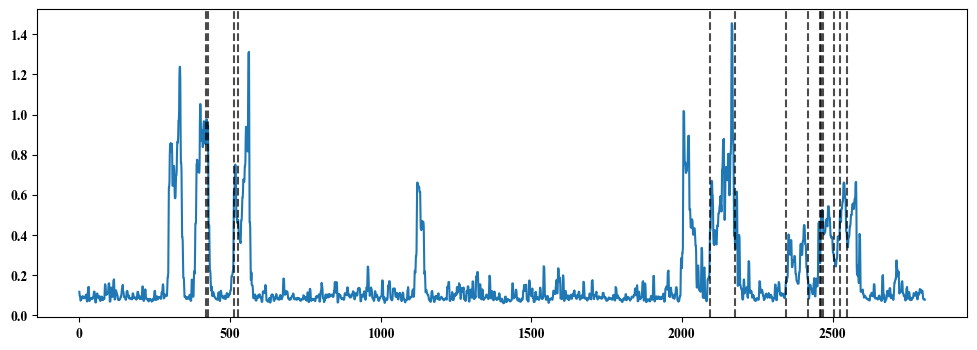

In [49]:
i = 0
sig = x[i]
l = 11
mma = ma(i, sig)
re = mma.get_pulses(l)
plt.figure(figsize=(12, 4))
plt.plot(sig)
for xx in re:
    left_idx = int(round(xx[0]))
    right_idx = int(round(xx[1]))
    plt.axvline(x=left_idx, color="black", linestyle="--", alpha=0.7)
    plt.axvline(x=right_idx, color="black", linestyle="--", alpha=0.7)

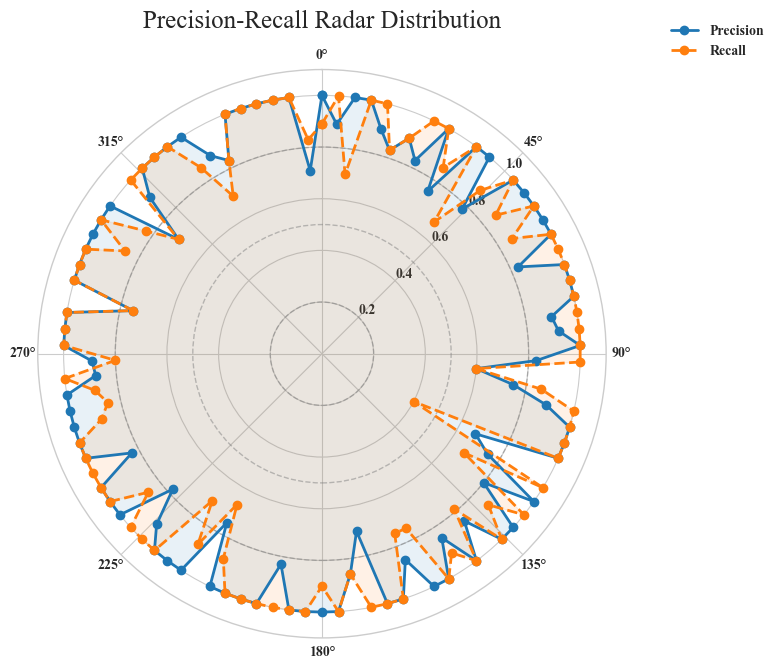

In [20]:
from matplotlib.patches import Circle

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'axes.titlesize': 14,
    'savefig.dpi': 300
})
# 数据预处理
def normalize_radar_data(data):
    return np.append(data, data[0])

angles = np.linspace(0, 2*np.pi, 98, endpoint=False)
angles = normalize_radar_data(angles)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# 绘制精度环
ax.plot(angles, normalize_radar_data(P), 'o-', color='#1f77b4', linewidth=2, label='Precision')
ax.fill(angles, normalize_radar_data(P), color='#1f77b4', alpha=0.1)

# 绘制召回环
ax.plot(angles, normalize_radar_data(R), 'o--', color='#ff7f0e', linewidth=2, label='Recall')
ax.fill(angles, normalize_radar_data(R), color='#ff7f0e', alpha=0.1)

# 设置极坐标轴
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(45)
ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_rlim(0, 1.1)

# 添加辅助圆环
for r in [0.2, 0.5, 0.8]:
    circle = Circle((0,0), r, transform=ax.transData._b, 
                   facecolor='none', edgecolor='gray', linestyle='--', alpha=0.5)
    ax.add_artist(circle)

plt.title('Precision-Recall Radar Distribution', fontsize=18, pad=30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("pic/radar.png")

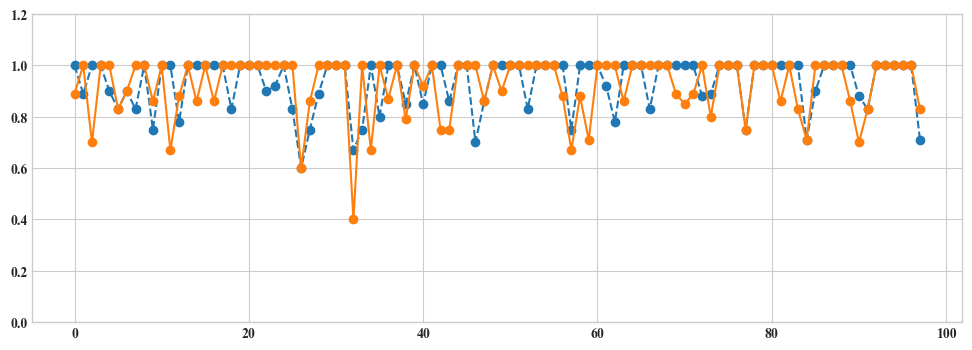

In [21]:
plt.figure(figsize=(12, 4))
n = len(P)
x = np.arange(n)
plt.plot(x, P, 'o--')
plt.plot(x, R, 'o-')
plt.ylim([0, 1.2])
plt.show()

In [28]:
print(total_match, total_fp, total_fn)

581 48 56
